In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import json

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

cwd = "/home/jonathan/Desktop/Perona_Research"

In [17]:
def create_csv(categories):
    data_types = ["test", "train"] # the dataset is split into test.json and train.json

    for category in categories:
        assert(os.path.exists(cwd + "/datasets/Animal_Kingdom/pose_estimation/annotation/" + category + "/"))
        
        out_csv = "image_directory"
    
        # add headers to beginning
        temp_file = open(cwd + "/datasets/Animal_Kingdom/pose_estimation/annotation/ak_P1/test.json", "r")
        temp_data = json.load(temp_file)
        for i in range(len(temp_data[0]["joints"])):
            out_csv += (",part" + str(i) + "_x,part" + str(i) + "_y")
        out_csv += "\n"

        for data_type in data_types:
            f = open(cwd + "/datasets/Animal_Kingdom/pose_estimation/annotation/" + category + "/" + data_type + ".json", "r")
            data = json.load(f)
            
            for item in data:
                out_csv += (item["image"] + ",")
                joint_locations = item["joints"]
                for joint in joint_locations:
                    out_csv += (str(joint[0]) + "," + str(joint[1]) + ",")
                out_csv = out_csv[:-1]
                out_csv += "\n"
            f.close()
    
        f = open(cwd + "/data_tools/PE_data_" + category + ".csv", "w")
        f.write(out_csv)
        f.close()
        print(f"Converted pose estimation data to csv for category {category}")

# create_csv(["ak_P1", "ak_P2", "ak_P3_amphibian", "ak_P3_bird", "ak_P3_bird", "ak_P3_fish", "ak_P3_mammal", "ak_P3_reptile"])

In [18]:
# combine different data sets together
def combine_csv(categories):
    list_cnt = 0
    content = set()
    assert(len(categories) != 0)
    for category in categories:
        path = cwd + "/data_tools/PE_data_" + category + ".csv"
        assert(os.path.exists(path))

        f = open(path, "r")
        text = f.read().splitlines()
        f.close()

        # remove the first row (it's the headers)
        text.pop(0)
        
        list_cnt += len(content)
        
        content = content.union(list(text))

    f = open(cwd + "/data_tools/PE_data_" + categories[0] + ".csv")
    header = f.read().splitlines()[0]
    f.close()

    converted_str = "\n".join(content)
    converted_str = header + "\n" + converted_str
    file = open(cwd + "/data_tools/PE_data_ALL.csv", "w")
    file.write(converted_str)
    file.close()

    print(f"Total unique data points: {len(content)}")

# combine_csv(["ak_P1", "ak_P2", "ak_P3_amphibian", "ak_P3_bird", "ak_P3_bird", "ak_P3_fish", "ak_P3_mammal", "ak_P3_reptile"])

In [19]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

In [20]:
class PEDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

0 (360, 640, 3) (23, 2)


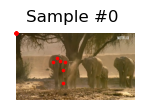

1 (360, 640, 3) (23, 2)


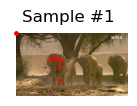

2 (360, 640, 3) (23, 2)


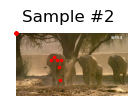

3 (360, 640, 3) (23, 2)


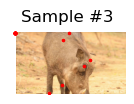

In [21]:
dataset = PEDataset(csv_file= cwd + "/data_tools/PE_data_ak_P3_mammal.csv",
                    root_dir= cwd + "/datasets/Animal_Kingdom/action_recognition/dataset/")

fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]

    print(i, sample['image'].shape, sample['landmarks'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)

    if i == 3:
        plt.show()
        break


<Figure size 640x480 with 0 Axes>

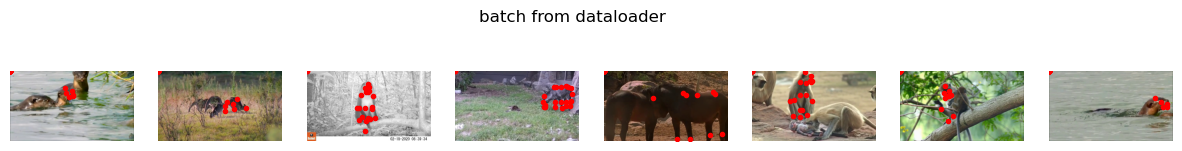

In [22]:
dataloader = DataLoader(dataset, batch_size=8,
                        shuffle=True, num_workers=0)

# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    grid_border_size = 2

    fig, axes = plt.subplots(1,batch_size, figsize=(15,2))
    fig.suptitle("batch from dataloader")

    for i in range(batch_size):
        axes[i].scatter(landmarks_batch[i, :, 0].numpy(), landmarks_batch[i, :, 1].numpy(),marker='.', c='r')
        axes[i].axis("off")
        axes[i].imshow(sample_batched["image"][i].numpy())

# each batch has batch_size images
for i_batch, sample_batched in enumerate(dataloader):
    # print(i_batch, sample_batched['image'].size(),
    #       sample_batched['landmarks'].size())

    # # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break